# Simple topography and geology generator #
C. Fandel 2020

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
import math

In [2]:
def point2index(point, xmin,ymin,zmin, dx,dy,dz):
    x   = point[0]
    y   = point[1]
    z   = point[2]
    col = (x - xmin) // dx
    row = (y - ymin) // dy
    lay = (z - zmin) // dz
    
    return [col,row, lay]

## 2D ##

flat DEM array: (80, 100) 600.0 600.0
DEM array: (80, 100) 252.5 600.0
Geology array: (80, 100) 1 2
Cost array: (80, 100) 0.4 0.9


Text(0.5, 0, 'Cost array')

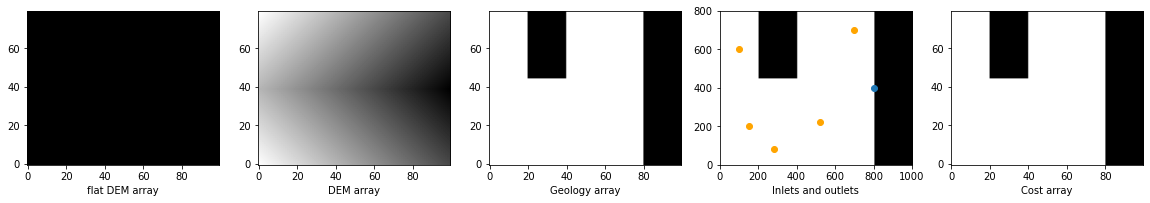

In [25]:
#Define grid:
model = 'valley1'

#Betteraz
if model == 'betteraz':
    dx = 20.0;  xmin = 572510-(dx/2);    xres = 300;  xmax = xmin + xres*dx
    dy = 20.0;  ymin = 250010 - (dy/2);  yres = 300;  ymax = ymin + yres*dy   
    dz = 20.0;  zmin = 0;                zres = 100;  zmax = zmin + zres*dz

#Gottesacker
if model == 'gottesacker':
    dx = 50.0;  xmin = 578287.5-(dx/2);     xres = 251;  xmax = xmin + xres*dx
    dy = 50.0;  ymin = 5240062.5 - (dy/2);  yres = 200;  ymax = ymin + yres*dy   
    dz = 50.0;  zmin = 0;                   zres = 100;  zmax = zmin + zres*dz

#Valley1:
if model == 'valley1':
    xmin = 0;  xres = 100;  dx = 10.0;  xmax = xmin + xres*dx
    ymin = 0;  yres = 80;   dy = 10.0;  ymax = ymin + yres*dy   
    zmin = 0;  zres = 60;   dz = 10.0;  zmax = zmin + zres*dz

#Create 2D flat topography array for comparison:
flat = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
flat = np.rot90(flat)
print('flat DEM array:', flat.shape, flat.min(), flat.max())    #print dimensions
#np.savetxt('flat_'+str(flat.shape[0])+'x'+str(flat.shape[1])+'.csv', flat, delimiter=',')  #export as csv
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.imshow(flat, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('flat DEM array')

#Create 2D topography array:
dem = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
valley  = yres//2                   #set which row to put the valley in
for ix in range(xres):               #move west to east along x indices (columns)
    dem[ix,:] = mx*ix + dem[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley+1):     #move down rows towards valley (north to south)
        dem[ix,iy] = my*iy + dem[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):            #move down y indices (rows) away from valley (south to north)
    dem[:,iy] = dem[:,yres-iy]           #insert a mirror image of the north side of the valley
dem = np.rot90(dem)                      #flip to have correct format for pykasso/agd-hfm
#dem = np.fliplr(dem)                     #optional - if want to have valley going the other direction
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
np.savetxt('dem_'+str(dem.shape[0])+'x'+str(dem.shape[1])+'.csv', dem, delimiter=',')  #export as csv
f.add_subplot(152, aspect='equal')
plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM array')

#Create 2D geology array:
limestone = 1
shale     = 2
geo = np.full((xres,yres), limestone)   #set 3D array of model dimensions filled with limestone value
geo[20:40, 0:35] = shale                #insert a block of shale in one corner to make array asymmetrical
geo[80:]        = shale                 #make one end shale
geo = np.rot90(geo)
print('Geology array:', geo.shape, geo.min(), geo.max())   
#np.savetxt('geo'+str(geo.shape[0])+'x'+str(geo.shape[1])+'.csv', geo, delimiter=',')  #export as csv
f.add_subplot(153, aspect='equal')
plt.imshow(geo, origin='lower', cmap='gray_r') #white = limestone
plt.xlabel('Geology array')

#Define 2D inlets and outlets:
inlets  = np.asarray([[100,600],[150,200],[520,220],[280,80],[700,700]])
outlets = np.asarray([[800,400]])
#np.savetxt("inlets.csv",  inlets,  delimiter=',')  #export as csv
#np.savetxt("outlets.csv", outlets, delimiter=',')  #export as csv
f.add_subplot(154, aspect='equal')
plt.imshow(geo, origin='lower', extent =[xmin,xmax,ymin,ymax], cmap='gray_r') #white = limestone
plt.xlabel('Inlets and outlets')
plt.scatter(inlets[:,0],  inlets[:,1], c='orange')
plt.scatter(outlets[:,0], outlets[:,1])

#Create 2D cost field:
Ckarst    = 0.4    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.9    #travel cost in nonkarst unit (should be high)
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full((xres,yres), Ckarst)    #set up array of default cost values (must be rotated 90 degrees to match geo array)
cost = np.rot90(cost)
cost[geo==1] = Ckarst     #assign low cost to limestone (2)
cost[geo==2] = Cnonkarst  #assign medium-high cost to all non-karst units
print('Cost array:', cost.shape, cost.min(), cost.max())    #print dimensions
#np.savetxt('cost'+str(cost.shape[0])+'x'+str(cost.shape[1])+'.csv', cost, delimiter=',')  #export as csv
f.add_subplot(155, aspect='equal')
plt.imshow(cost, origin='lower', cmap='gray_r') #darker=higher cost
plt.xlabel('Cost array')

## Topo generator

Modified from https://github.com/hnhaefliger/pyTerrain

DEM array: (80, 100) -3.12214329001156 22.71211547983181


Text(0.5, 0, 'DEM array')

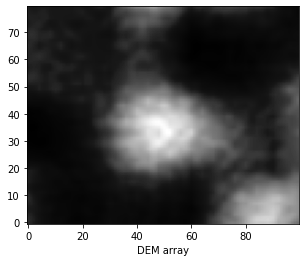

In [29]:
sys.path.append('C:/Users/Chloe/Documents/GitHub/pyTerrain') #path to local version of package
import perlin             #in this case, "perlin" is the name of the .py file with all of the functions in it

width  = xres # map width
length = yres # map length

############ Noise variables

n1div = 30 # landmass distribution
n2div = 4 # boulder distribution
n3div = 1 # rock distribution

n1scale = 20 # landmass height
n2scale = 2 # boulder scale
n3scale = 0.5 # rock scale

noise1 = perlin.noise(width / n1div, length / n1div) # landmass / mountains
noise2 = perlin.noise(width / n2div, length / n2div) # boulders
noise3 = perlin.noise(width / n3div, length / n3div) # rocks

zroot = 2
zpower = 2.5

#Create topography:
points = []
for x in range(-int(width/2), int(width/2)):
    for y in range(-int(length/2), int(length/2)):
        x1 = x + width/2 
        y1 = y + length/2
        z = noise1.perlin(x1 / n1div, y1 / n1div) * n1scale # add landmass
        z += noise2.perlin(x1 / n2div, y1 / n2div) * n2scale # add boulders
        z += noise3.perlin(x1 / n3div, y1 / n3div) * n3scale # add rocks
        if z >= 0:
            z = -math.sqrt(z)
        else:
            z = ((-z) ** (1 / zroot)) ** zpower
        points.append([x, y, z]) 
        
#Reformat into array, view, & export:
df = pd.DataFrame(points, columns=['x','y','z'])             #convert to df to be able to use pivot table feature
table = df.pivot_table(values='z', index='x', columns='y')   #convert (x,y,z) to a table of dim (x,y) with values z
dem = table.to_numpy()                                       #convert to numpy array for viewing and export

dem = np.rot90(dem)                      #flip to have correct format for pykasso/agd-hfm
#dem = np.fliplr(dem)                    #optional - if want to change x alignment
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
np.savetxt('random_dem_'+str(dem.shape[0])+'x'+str(dem.shape[1])+'.csv', dem, delimiter=',')  #export as csv
plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM array')

## 3D
In progress

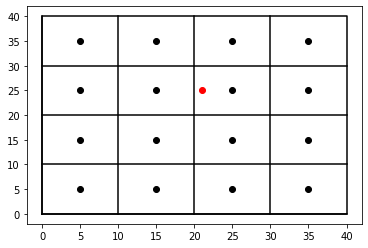

In [59]:
#Visualize grid:

xmin = 0;  dx = 10.;  xres = 4;  xmax = xmin + xres*dx
ymin = 0;  dy = 10.;  yres = 4;  ymax = ymin + yres*dy

xpoints  = np.linspace(xmin,          xmax-dx,       xres)   #left corners
xcenters = np.linspace(xmin + (dx/2), xmax - (dx/2), xres)   #centerpoints
ypoints  = np.linspace(ymin,          ymax-dx,       yres)   #bottom corners
ycenters = np.linspace(ymin + (dy/2), ymax - (dx/2), yres)   #centerpoints
X,Y      = np.meshgrid(xcenters,ycenters)

plt.scatter(X,Y, c='k')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin], c='k')
for i in range(xres):
    plt.plot([xpoints[i],xpoints[i]],[ymin,ymax], c='k')
for j in range(yres):
    plt.plot([xmin,xmax],[ypoints[j],ypoints[j]], c='k')

x = 21; y = 25
plt.scatter(x,y, c='r')


flat DEM array: (80, 100) 600.0 600.0
DEM array: (80, 100) 252.5 600.0
Contact array: (80, 100) 311.0 450.0
Geology array: (80, 100, 60) 1.0 2.0


IndexError: index 60 is out of bounds for axis 2 with size 60

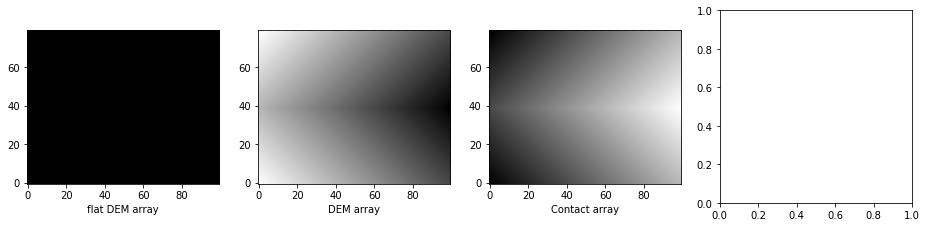

In [58]:
#Define grid:
xmin = 0;  xres = 100;  dx = 10.0;  xmax = xmin + xres*dx
ymin = 0;  yres = 80;   dy = 10.0;  ymax = ymin + yres*dy   
zmin = 0;  zres = 60;   dz = 10.0;  zmax = zmin + zres*dz

#Create 2D flat topography array for comparison:
flat = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
flat = np.rot90(flat)
print('flat DEM array:', flat.shape, flat.min(), flat.max())    #print dimensions
np.savetxt('flat_'+str(flat.shape[0])+'x'+str(flat.shape[1])+'.csv', flat, delimiter=',')  #export as csv
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.imshow(flat, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('flat DEM array')

#Create 2D topography array:
dem = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
valley  = yres//2                   #set which row to put the valley in
for ix in range(xres):               #move west to east along x indices (columns)
    dem[ix,:] = mx*ix + dem[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley+1):     #move down rows towards valley (north to south)
        dem[ix,iy] = my*iy + dem[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):            #move down y indices (rows) away from valley (south to north)
    dem[:,iy] = dem[:,yres-iy]           #insert a mirror image of the north side of the valley
dem = np.rot90(dem)
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
np.savetxt('dem_'+str(dem.shape[0])+'x'+str(dem.shape[1])+'.csv', dem, delimiter=',')  #export as csv
f.add_subplot(152, aspect='equal')
plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM array')
#Convert from elevations to z cell indices:
idem = np.full((xres,yres), zres, dtype=int)    #create an array with model x and y dimensions, filled with max z index
for iy in range(yres):
    for ix,z in enumerate(dem[:,iy]):
        #[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz]) #use new fn
        #[[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])   #use built-in
        [xind,yind,zind] = point2index([0,0,z], xmin,ymin,zmin, dx,dy,dz)  #convert x,y,z coord to array indices
        idem[ix,iy] = zind-1 #correct to be index below
        #idem[ix,iy]  = zind


#Create 2D array of lower contact between karst and nonkarst:
zstart = zmax - (zmax-zmin)//4
zcontact = np.full((xres,yres), zstart, dtype=float) #create array with the model x and y dimensions, filled with the max z value
mx = -0.1 * dx                 #set the slope in the x direction (west to east)
my = -0.1 * dy                 #set the slope in the y direction (north to south)
valley  = yres//2              #set which row to put the valley in
for ix in range(xres):                        #move west to east along columns
    zcontact[ix,:] = mx*ix + zcontact[0,0]    #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(ymin,valley+1):           #move down rows towards valley (north to south)
        zcontact[ix,iy] = my*iy + zcontact[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):                      #move down rows away from valley (south to north)
    zcontact[:,iy] = zcontact[:,yres-iy]           #insert a mirror image of the north side of the valley
zcontact = np.rot90(zcontact)
print('Contact array:', zcontact.shape, zcontact.min(), zcontact.max())   
np.savetxt('zcontact'+str(zcontact.shape[0])+'x'+str(zcontact.shape[1])+'.csv', zcontact, delimiter=',')  #export as csv
f.add_subplot(153, aspect='equal')
plt.imshow(zcontact, origin='lower', cmap='gray_r') #white = limestone
plt.xlabel('Contact array')

#Create 3D geology array:
limestone = 1
shale     = 2
#Convert from coordinates to cell indices:
icontact = np.empty((xres,yres))
for iy in range(yres):
    for ix,z in enumerate(zcontact[:,iy]):
        ##[[xind,yind,zind],error] = IndexFromPoint([0,0,z], [xres,yres,zres], [xmin,ymin,zmin], [dx,dy,dz])
        #[[xind,yind,zind],error] = hfmIn.IndexFromPoint([0,0,z])
        [xind,yind,zind] = point2index([0,0,z], xmin,ymin,zmin, dx,dy,dz)  #convert x,y,z coord to array indices
        icontact[ix,iy] = zind - 1
#Create 3D geology array (the integer in each cell indicates the formation present in that cell):
geo = np.empty((xres,yres,zres))   #set empty 3D array of model dimensions
for ix in range(xres):            #loop over cols, rows, & layers
    for iy in range(yres):
        for iz in range(zres):             #for each cell, 
            if iz <= icontact[ix,iy]:    #if layer is below the contact index (i.e. has a lower index),
                geo[ix,iy,iz] = shale        #assign for shale
            if iz > icontact[ix,iy]:     #if layer is above the contact index (i.e. has a higher index),
                geo[ix,iy,iz] = limestone        #assign for limestone
geo[0:26, 0:26] = shale                     #insert a block of shale in one corner to make array asymmetrical
geo = np.rot90(geo)
print('Geology array:', geo.shape, geo.min(), geo.max())   
#np.savetxt('geo'+str(geo.shape[0])+'x'+str(geo.shape[1])+'x'+str(geo.shape[2])+'.csv', geo, delimiter=',')  #export as csv
f.add_subplot(154, aspect='equal')
plt.imshow(geo[:,:,idem], origin='lower', cmap='gray_r') #white = limestone
plt.xlabel('Geology array')

sys.exit()
#Define 2D inlets and outlets:
inlets  = np.asarray([[100,600],[150,200],[520,220],[280,80],[700,700]])
outlets = np.asarray([[800,400]])
np.savetxt("inlets.csv",  inlets,  delimiter=',')  #export as csv
np.savetxt("outlets.csv", outlets, delimiter=',')  #export as csv
f.add_subplot(154, aspect='equal')
plt.imshow(geo, origin='lower', extent =[xmin,xmax,ymin,ymax], cmap='gray_r') #white = limestone
plt.xlabel('Inlets and outlets')
plt.scatter(inlets[:,0],  inlets[:,1], c='orange')
plt.scatter(outlets[:,0], outlets[:,1])

#Create 2D cost field:
Ckarst    = 0.4    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.9    #travel cost in nonkarst unit (should be high)
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full((xres,yres), Ckarst)    #set up array of default cost values (must be rotated 90 degrees to match geo array)
cost = np.rot90(cost)
cost[geo==1] = Ckarst     #assign low cost to limestone (2)
cost[geo==2] = Cnonkarst  #assign medium-high cost to all non-karst units
print('Cost array:', cost.shape, cost.min(), cost.max())    #print dimensions
np.savetxt('cost'+str(cost.shape[0])+'x'+str(cost.shape[1])+'.csv', cost, delimiter=',')  #export as csv
f.add_subplot(155, aspect='equal')
plt.imshow(cost, origin='lower', cmap='gray_r') #darker=higher cost
plt.xlabel('Cost array')